Required Modifications
1)Add more features and label to the code
2)Add more hyper-parameters to generate chormosomes
3)Change the RMSE to acc

In [ ]:
!pip install deap

     |████████████████████████████████| 163kB 31.8MB/s 


In [ ]:
!pip install bitstring

In [ ]:
#Import necessary packages

import numpy as np
import pandas as pd
from datetime import datetime
from sklearn.metrics import mean_squared_error

from deap import base, creator, tools, algorithms
from scipy.stats import bernoulli
from bitstring import BitArray
from sklearn.preprocessing import MinMaxScaler

from sklearn.preprocessing import LabelEncoder
from keras.utils import np_utils

from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import CuDNNLSTM
from keras.layers import Dense
from keras.layers import Dropout
from keras import optimizers

np.random.seed(1120)

Using TensorFlow backend.


In [ ]:
dataset = pd.read_csv("Driving Data(KIA SOUL)_(150728-160714)_(10 Drivers_A-J).csv")
Y=dataset.Class
X=dataset.drop('Class',axis=1)
data=np.array(X)
print(data)

[[ 2.688e+02  0.000e+00  5.200e+00 ... -3.400e+00  1.000e+00  1.000e+00]
 [ 2.432e+02  0.000e+00  6.100e+00 ... -3.600e+00  2.000e+00  1.000e+00]
 [ 2.176e+02  0.000e+00  5.200e+00 ... -3.600e+00  3.000e+00  1.000e+00]
 ...
 [ 3.456e+02  0.000e+00  6.600e+00 ... -1.320e+01  2.566e+03  2.000e+00]
 [ 3.328e+02  0.000e+00  5.700e+00 ... -1.330e+01  2.567e+03  2.000e+00]
 [ 2.816e+02  0.000e+00  5.200e+00 ... -1.330e+01  2.568e+03  2.000e+00]]


In [ ]:
#standardize dataset
from sklearn import preprocessing
min_max_scaler = preprocessing.MinMaxScaler()
x_train_scaled = min_max_scaler.fit_transform(data)
x_train_scaled

array([[2.45901639e-02, 0.00000000e+00, 5.20000000e-02, ...,
        4.90306561e-01, 0.00000000e+00, 0.00000000e+00],
       [2.22482436e-02, 0.00000000e+00, 6.10000000e-02, ...,
        4.90115557e-01, 3.39328130e-04, 0.00000000e+00],
       [1.99063232e-02, 0.00000000e+00, 5.20000000e-02, ...,
        4.90115557e-01, 6.78656261e-04, 0.00000000e+00],
       ...,
       [3.16159251e-02, 0.00000000e+00, 6.60000000e-02, ...,
        4.80947378e-01, 8.70376654e-01, 1.00000000e+00],
       [3.04449649e-02, 0.00000000e+00, 5.70000000e-02, ...,
        4.80851877e-01, 8.70715982e-01, 1.00000000e+00],
       [2.57611241e-02, 0.00000000e+00, 5.20000000e-02, ...,
        4.80851877e-01, 8.71055310e-01, 1.00000000e+00]])

In [ ]:
#convert Y(output label) to numpy array
array_y=Y.to_numpy()

#convert label class to one hot encoded format
encoder = LabelEncoder()
encoder.fit(array_y)
encoded_Y = encoder.transform(array_y)
encoded_y = np_utils.to_categorical(encoded_Y)
print(encoded_y)

[[1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 [1. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]]


In [ ]:
#Add the parameters into chromosomes and define the LSTM network model
#import random
import math

def train_evaluate(ga_individual_solution):   
    # Decode GA solution to integer for num_neurons1, epochs and batch_size 
    num_neurons1_bits = BitArray(ga_individual_solution[0:9])
    num_neurons2_bits = BitArray(ga_individual_solution[9:18])
    epoch_bits = BitArray(ga_individual_solution[18:25]) 
    batch_size_bits = BitArray(ga_individual_solution[25:35])
    learning_rate_bits = BitArray(ga_individual_solution[35:])
   
    num_neurons1 = num_neurons1_bits.uint
    num_neurons2 = num_neurons2_bits.uint
    epoch = epoch_bits.uint
    Batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    learning_rate = temp*(math.exp(-9))
    
    print('\nNum of neurons1: ', num_neurons1,'\nNum of neurons2',num_neurons2, '\nEpoch:', epoch,'\nBatch size:',Batch_size,'\nLearning rate:',learning_rate)
    
    # Return fitness score of 100 if window_size or num_unit is zero
    if num_neurons1 < 100 or num_neurons2 < 100 or epoch < 100 or Batch_size < 500  or learning_rate < 0:
      return 0,
    
    #split into train and validation (80/20)
    x_train,x_test,y_train,y_test=train_test_split(x_train_scaled,encoded_y,test_size=0.2)
    
    #converting the input train and test set to array format
    x_train=np.array(x_train)
    x_test=np.array(x_test)
    
    #reshape input data according to LSTM model requirements
    x_train_modified = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
    x_test_modified = x_test.reshape(x_test.shape[0],1,x_test.shape[1])
    
    #Design the LSTM model
    
    optimizer=optimizers.Adam(lr=learning_rate, beta_1=0.9, beta_2=0.999, amsgrad=False)
    
    model = Sequential()
    model.add(CuDNNLSTM(num_neurons1, input_shape=(x_train_modified.shape[1],x_train_modified.shape[2]), return_sequences=True))
    model.add(Dropout(0.2))
    model.add(CuDNNLSTM(num_neurons2))
    model.add(Dropout(0.2))
    model.add(Dense(y_train.shape[1], activation='softmax'))
    model.compile(loss='categorical_crossentropy',optimizer='adam',metrics=['accuracy'])
    model.summary()
    
    #model.fit(x_train_modified, y_train, epochs=epoch, batch_size=Batch_size)

    history=model.fit(x_train_modified, y_train, epochs=epoch, batch_size=Batch_size,verbose=0)
    y_pred = model.predict(x_test_modified)
    acc=history.history['acc']
    maxacc=round(max(acc),5)
    #rmse = np.sqrt(mean_squared_error(y_test, y_pred))
    print('Validation Accuracy : ', maxacc,'\n')
    #print('Accuracy:', max(acc))
    
    return maxacc,

In [ ]:
population_size = 50
num_generations = 20
gene_length = 42

# As we are trying to minimize the RMSE score, that's why using -1.0. 
# In case, when you want to maximize accuracy for instance, use 1.0
creator.create('FitnessMax', base.Fitness, weights = (1.0,))
creator.create('Individual', list , fitness = creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register('binary', bernoulli.rvs, 0.5)
toolbox.register('individual', tools.initRepeat, creator.Individual, toolbox.binary, n = gene_length)
toolbox.register('population', tools.initRepeat, list , toolbox.individual)

toolbox.register('mate', tools.cxOrdered)
toolbox.register('mutate', tools.mutShuffleIndexes, indpb = 0.6)
toolbox.register('select', tools.selRoulette)
toolbox.register('evaluate', train_evaluate)

population = toolbox.population(n = population_size)
start_time = datetime.now()
print("Start time:", start_time)
r = algorithms.eaSimple(population, toolbox, cxpb = 0.4, mutpb = 0.1, ngen = num_generations, verbose = False)
end_time = datetime.now()
print('End time:',end_time)
time_elapsed = end_time-start_time
print('Time elapsed (hh:mm:ss.ms) {}'.format(time_elapsed))

Start time: 2020-03-07 10:28:30.517595

Num of neurons1:  289 
Num of neurons2 226 
Epoch: 30 
Batch size: 312 
Learning rate: 0.012587800016841314

Num of neurons1:  82 
Num of neurons2 450 
Epoch: 29 
Batch size: 88 
Learning rate: 0.007404588245200774

Num of neurons1:  332 
Num of neurons2 129 
Epoch: 89 
Batch size: 814 
Learning rate: 0.012217570604581276

Num of neurons1:  39 
Num of neurons2 240 
Epoch: 31 
Batch size: 737 
Learning rate: 0.0028384254939936297

Num of neurons1:  65 
Num of neurons2 122 
Epoch: 12 
Batch size: 406 
Learning rate: 0.012094160800494597

Num of neurons1:  402 
Num of neurons2 383 
Epoch: 48 
Batch size: 671 
Learning rate: 0.009502554914674326

Num of neurons1:  356 
Num of neurons2 128 
Epoch: 2 
Batch size: 894 
Learning rate: 0.004195933338947105

Num of neurons1:  174 
Num of neurons2 352 
Epoch: 84 
Batch size: 919 
Learning rate: 0.0035788843185137072

Num of neurons1:  278 
Num of neurons2 54 
Epoch: 107 
Batch size: 110 
Learning rate: 0.00

In [ ]:
#Consolidate the best individuals


best_individuals = tools.selBest(population,k = 1)
best_num_neurons1 = None
best_num_neurons2 = None
best_epoch = None
best_batch_size = None
best_learning_rate = None

for bi in best_individuals:
    num_neurons1_bits = BitArray(bi[0:9])
    num_neurons2_bits = BitArray(bi[9:18])
    epoch_bits = BitArray(bi[18:25])
    batch_size_bits = BitArray(bi[25:35])
    learning_rate_bits = BitArray(bi[35:]) 
    
    best_num_neurons1 = num_neurons1_bits.uint
    best_num_neurons2 = num_neurons2_bits.uint
    best_epoch = epoch_bits.uint
    best_batch_size = batch_size_bits.uint
    temp = learning_rate_bits.uint
    best_learning_rate = temp*(math.exp(-9))
    print('\nNum of neurons1: ', best_num_neurons1, '\nNum of neurons2: ', best_num_neurons2,  '\nEpoch:', best_epoch, '\nBatch_size:', best_batch_size,'\nLearning rate:',best_learning_rate)


Num of neurons1:  470 
Num of neurons2:  275 
Epoch: 124 
Batch_size: 549 
Learning rate: 0.0056768509879872595


In [ ]:
x_train,x_test,y_train,y_test=train_test_split(x_train_scaled,encoded_y,test_size=0.2)
    
#converting the input train and test set to array format
x_train=np.array(x_train)
x_test=np.array(x_test)

x_train_modified = x_train.reshape(x_train.shape[0],1,x_train.shape[1])
x_test_modified = x_test.reshape(x_test.shape[0],1,x_test.shape[1])



print(x_test_modified.shape)

(18876, 1, 53)


In [ ]:
#rmse function implementation
from keras import backend
 
def rmse (y_test, y_pred):
	return backend.sqrt(backend.mean(backend.square(y_pred - y_test), axis=-1))

In [ ]:
  #Train model using the best individual obtained from the genetic algorithm  
optimizer=optimizers.Adam(lr=0.0056768509879872595, beta_1=0.9, beta_2=0.999, amsgrad=False)

model = Sequential()
model.add(CuDNNLSTM(470, input_shape=(x_train_modified.shape[1],x_train_modified.shape[2]), return_sequences=True))
model.add(Dropout(0.2))
model.add(CuDNNLSTM(275))
model.add(Dropout(0.2))
model.add(Dense(y_train.shape[1], activation='softmax')) 
model.compile(loss='categorical_crossentropy', optimizer='adam',metrics=['accuracy'])
model.summary()

history=model.fit(x_train_modified, y_train, validation_split = 0.33, epochs=124, batch_size=549)

#rmse = history.history['rmse']
#minrmse = min(rmse)    
#print('RMSE:',minrmse)    








Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.


Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
cu_dnnlstm_1 (CuDNNLSTM)     (None, 1, 470)            987000    
_________________________________________________________________
dropout_1 (Dropout)          (None, 1, 470)            0         
_________________________________________________________________
cu_dnnlstm_2 (CuDNNLSTM)     (None, 275)               821700    
_________________________________________________________________
dropout_2 (Dropout)          (None, 275)               0         
_________________________________________________________________
dense_1 (Dense)              (None, 10)                2760      
Total params: 1,811,460
Trainable params: 1,811,460
Non-trainable params: 0
_______________________________________________________

In [ ]:
# evaluate the model
_, train_acc = model.evaluate(x_train_modified, y_train, verbose=1)
_, test_acc = model.evaluate(x_test_modified, y_test, verbose=1)
print('Train: %.4f, Test: %.4f' % (train_acc, test_acc))

18876/18876 [==============================] - 2s 80us/step
Train: 0.9966, Test: 0.9946


In [ ]:
y_pred = model.predict(x_test_modified)

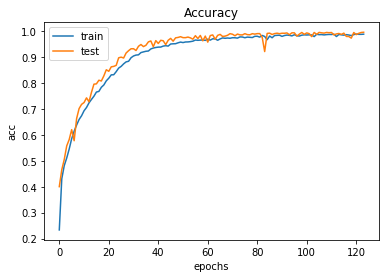

In [ ]:
import matplotlib.pyplot as plt

#acc= history.history['acc']

epochs_range = range(157)
plt.plot(history.history['acc'])
plt.plot(history.history['val_acc'])
plt.xlabel("epochs")
plt.ylabel("acc")
plt.legend(['train', 'test'], loc='upper left')
plt.title("Accuracy")
plt.show()

In [ ]:
import matplotlib.pyplot as plt
# summarize history for accuracy
plt.plot(history.history['rmse'])
plt.plot(history.history['val_rmse'])
plt.title('model rmse')
plt.ylabel('rmse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()

KeyError: ignored

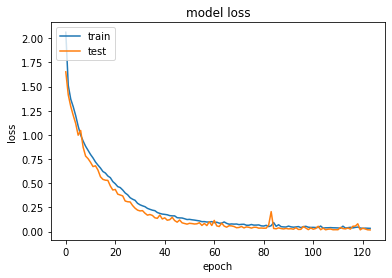

In [ ]:
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show() 

In [ ]:
maximumacc=max(acc)
print('Accuracy:',maximumacc)

NameError: ignored

In [ ]:
from sklearn.metrics import roc_curve, auc

n_classes = y_test.shape[1]

# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(n_classes):
    fpr[i], tpr[i], _ = roc_curve(y_test[:, i], y_pred[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])

# Compute micro-average ROC curve and ROC area
fpr["micro"], tpr["micro"], _ = roc_curve(y_test.ravel(), y_pred.ravel())
roc_auc["micro"] = auc(fpr["micro"], tpr["micro"])

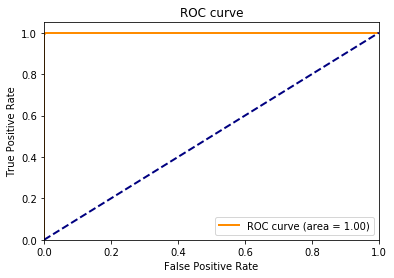

In [ ]:
plt.figure()
lw = 2
plt.plot(fpr[2], tpr[2], color='darkorange',
         lw=lw, label='ROC curve (area = %0.2f)' % roc_auc[1])
plt.plot([0, 1], [0, 1], color='navy', lw=lw, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve')
plt.legend(loc="lower right")
plt.show()

/usr/local/lib/python3.6/dist-packages/ipykernel_launcher.py:12: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  if sys.path[0] == '':


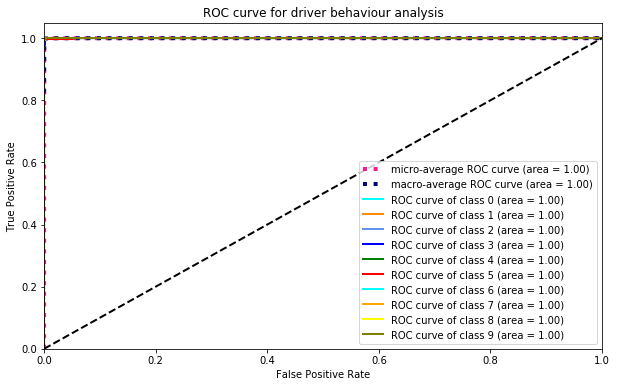

In [ ]:
# Compute macro-average ROC curve and ROC area
from sklearn.metrics import roc_curve, auc
import matplotlib.pyplot as plt
from scipy import interp
from itertools import cycle

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(n_classes)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(n_classes):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= n_classes

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure(figsize=(10,6))
plt.plot(fpr["micro"], tpr["micro"],
         label='micro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["micro"]),
         color='deeppink', linestyle=':', linewidth=4)

plt.plot(fpr["macro"], tpr["macro"],
         label='macro-average ROC curve (area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=4)

colors = cycle(['aqua', 'darkorange', 'cornflowerblue', 'blue','green','red','cyan','orange','yellow','olive'])
for i, color in zip(range(n_classes), colors):
    plt.plot(fpr[i], tpr[i], color=color, lw=lw,
             label='ROC curve of class {0} (area = {1:0.2f})'
             ''.format(i, roc_auc[i]))

plt.plot([0, 1], [0, 1], 'k--', lw=lw)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC curve for driver behaviour analysis')
plt.legend(loc="lower right")
plt.show()

In [ ]:
print(y_pred[:4], y_test[:4])

[[9.81848717e-13 5.18289962e-05 8.62409797e-06 3.92565062e-06
  4.28298265e-11 2.68062702e-14 9.99697328e-01 6.56532995e-10
  2.38332228e-04 2.54039456e-09]
 [2.60120510e-22 1.44532205e-22 2.72475380e-12 3.31669553e-11
  1.00000000e+00 1.37371191e-11 1.32239554e-24 3.99297448e-08
  4.65563486e-15 1.07008714e-10]
 [1.12451037e-09 6.72388888e-16 4.33485921e-11 7.93386974e-08
  1.32772682e-09 9.11581299e-09 3.90601468e-18 1.61135702e-07
  1.41848914e-05 9.99985576e-01]
 [8.18112225e-16 8.23034352e-09 1.01536017e-16 1.50252852e-10
  3.37437404e-11 9.99962211e-01 8.06674123e-08 1.28822708e-09
  5.48388210e-11 3.76948119e-05]] [[0. 0. 0. 0. 0. 0. 1. 0. 0. 0.]
 [0. 0. 0. 0. 1. 0. 0. 0. 0. 0.]
 [0. 0. 0. 0. 0. 0. 0. 0. 0. 1.]
 [0. 0. 0. 0. 0. 1. 0. 0. 0. 0.]]


In [ ]:
!python -c 'import tensorflow; print(tensorflow.__version__)'

1.15.0


population size: 50, 100, 200
number of generations: 100, 200, 500
mutation probability: 0.1, 0.2, 0.5, and sometimes 0.8, 1.0
crossover rate: 0.9, 0.8, 0.6